In [1]:
# 1. Import and Install Dependencies

In [2]:
""" !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib """


' !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib '

In [11]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from pose_estimation_model import create_model


In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR CONVERSION RGB 2 BGR
    return image, results

In [6]:
def draw_styled_landmarks(image, results):

    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

# 4. Setup Folders for Collection

In [8]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Dataset') 

# Actions that we try to detect
actions = np.array(['flute', 'violin', 'trumpet', 'saxophone', 'no action'])

# number of videos that we collect for each instrument (we need to create a dataset to train our model on: the more data we have, the better)

# set here the number of the sequences you want to track
no_sequences = 10

# number of frames in a video, which are sequence of frames to be fed to the LSTM Neural Network
sequence_length = 30


In [9]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

: 

In [ ]:
cap.release()
cv2.destroyAllWindows()

: 

# 6. Preprocess Data and Create Labels and Features

In [37]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [38]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'flute': 0, 'violin': 1, 'trumpet': 2, 'saxophone': 3, 'no action': 4}

In [39]:
TRAINING_PATH = 'Dataset' # location of your training dataset

In [40]:
def get_sequences_and_labels(path):
    sequences, labels = [], []
    for action in actions:
        for sequence in np.array(os.listdir(os.path.join(path, action))).astype(int):
            window = []
            for frame_num in range(sequence_length):
                res = np.load(os.path.join(path, action, str(sequence), "{}.npy".format(frame_num)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
    return sequences, labels

In [41]:
def process_dataset(sequences, labels):
    X = np.array(sequences)
    y = to_categorical(labels).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
   
    print('Labels shape: {}' .format(np.array(labels).shape))
    print('Shape of X: {}' .format(X.shape))
    print('Sequences shape: {}' .format(np.array(sequences).shape))
    print('Shape of y_test: {}' .format(y_test.shape))
    return X_train, X_test, y_train, y_test

In [42]:
sequences, labels = get_sequences_and_labels(TRAINING_PATH)

In [43]:
X_train, X_test, y_train, y_test = process_dataset(sequences, labels)

Labels shape: (50,)
Shape of X: (50, 30, 258)
Sequences shape: (50, 30, 258)
Shape of y_test: (5, 5)


# 7. Build and Train LSTM Neural Network

In [12]:
model = create_model(sequence_length, actions)

In [13]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            82688     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 237,317
Trainable params: 237,317
Non-trai

In [ ]:
model.fit(X_train, y_train, epochs=2000, validation_split=.1, callbacks=[callbacks])

Epoch 1/2000
2/2 [==============================] - 3s 720ms/step - loss: 1.6105 - categorical_accuracy: 0.2750 - val_loss: 1.6073 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/2000
2/2 [==============================] - 0s 87ms/step - loss: 1.6004 - categorical_accuracy: 0.3000 - val_loss: 1.6151 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/2000
2/2 [==============================] - 0s 90ms/step - loss: 1.5794 - categorical_accuracy: 0.3250 - val_loss: 1.6879 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/2000
2/2 [==============================] - 0s 92ms/step - loss: 1.5405 - categorical_accuracy: 0.3000 - val_loss: 1.6474 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/2000
2/2 [==============================] - 0s 79ms/step - loss: 1.4489 - categorical_accuracy: 0.4000 - val_loss: 1.9635 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/2000
2/2 [==============================] - 0s 82ms/step - loss: 1.3447 - categor

: 

# 9. Save Weights

In [20]:
VERSION_NAME = 'version_1.h5' 

In [ ]:
model.save(VERSION_NAME)

: 

In [ ]:
model.load_weights(VERSION_NAME)

: 

# 10. Fine tuning

In [15]:
FINE_TUNING_PATH = 'Fine Tuning'

In [44]:
sequences, labels = get_sequences_and_labels(FINE_TUNING_PATH)

In [45]:
X_train, X_test, y_train, y_test = process_dataset(sequences, labels)

Labels shape: (50,)
Shape of X: (50, 30, 258)
Sequences shape: (50, 30, 258)
Shape of y_test: (5, 5)


In [46]:
# redefine the model
model = create_model(sequence_length, actions)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [47]:
model.load_weights(VERSION_NAME) # restore the previously trained model

In [ ]:
model.fit(X_train, y_train, epochs=2000, validation_split=.1, callbacks=[callbacks])

In [21]:
VERSION_NAME = 'fine_tuning.h5'

In [ ]:
model.save_weights(VERSION_NAME)


NameError: name 'model' is not defined

: 

# 11. Final Test

In [48]:
model.load_weights(VERSION_NAME)

In [49]:
res = model.predict(X_test)

1/1 [==============================] - 0s 364ms/step


In [50]:
from scipy import stats

In [61]:
colors = [(245,117,16), (117,245,16), (16,117,245), (230,200,100), (230,200,100)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

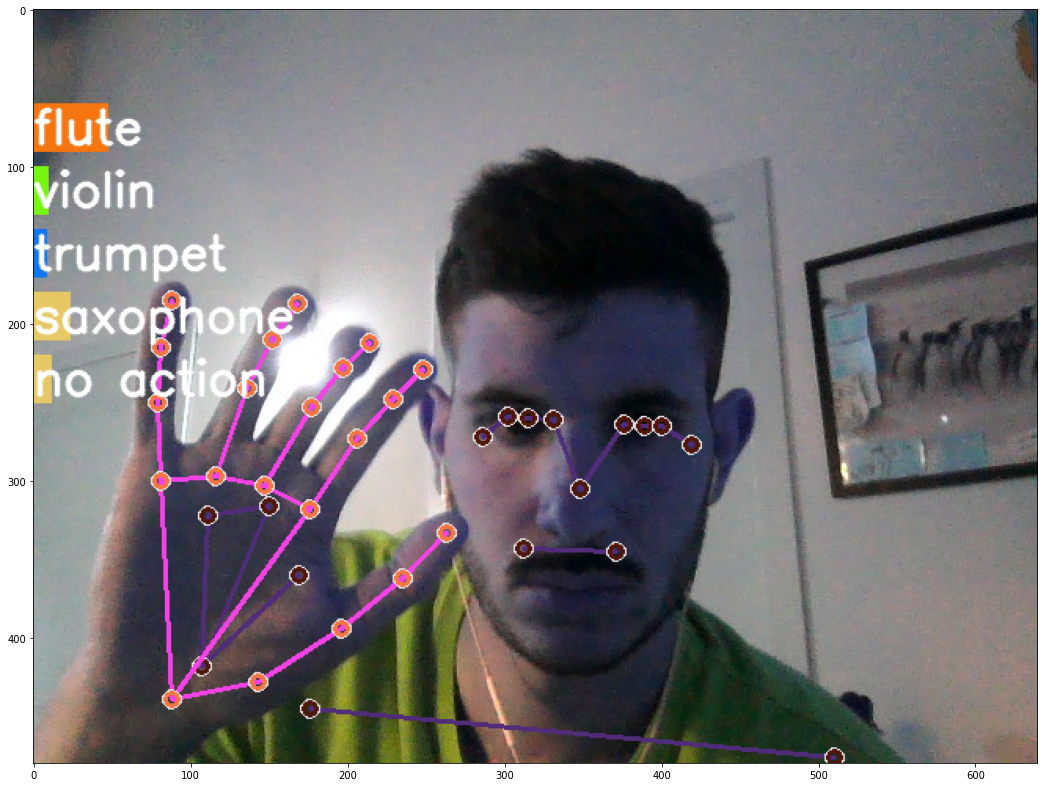

In [62]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [63]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.6

cap = cv2.VideoCapture(0);
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-sequence_length:]
        
        if len(sequence) == sequence_length:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            prediction = np.argmax(res)
            print(actions[prediction])
            predictions.append(prediction)
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

KeyboardInterrupt: 

In [64]:
cap.release()
cv2.destroyAllWindows()